# Importing all necessary libraries

In [3]:
!pip install optuna
!pip install fancyimpute


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 13.9 MB/s eta 0:00:00
  Created wheel for fancyimpute: filename=fancyimpute-0.7.0-py3-none-any.whl size=29879 sha256=c57339730fe9a250477f3e7bdcc136f61512d8f1ffa03677ddfa7a13925e92e8
  Stored in directory: /root/.cache/pip/wheels/7b/0c/d3/ee82d1fbdcc0858d96434af108608d01703505d453720c84ed
  Created wheel for knnimpute: filename=knnimpute-0.1.0-py3-none-any.whl size=11329 sha256=105bab951c89965374f5498de529a7382e9eb4b9f51ec98cf0cb5c5289448129
  Stored in directory: /root/.cache/pip/wheels/46/06/a5/45a724630562413c374e29c08732411d496092408b3a7bf754
Successfully built fancyimpute knnimpute


In [4]:
# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Imputation
from fancyimpute import IterativeImputer

# Visualize missing
import missingno as msno

# Models
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.base import TransformerMixin

# Model Selection
from sklearn.model_selection import train_test_split

# Model evaluation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score

%matplotlib inline

## Load Data

In [6]:
df_pdf = pd.read_csv('final.csv')
# Display first 5 Rows.
df_pdf.head()

,MD5,pdfsize,metadata size,pages,xref length,title characters,isEncrypted,embedded files,images,contains text,...,AA_Obfuscated,OpenAction_Obfuscated,AcroForm_Obfuscated,JBIG2Decode_Obfuscated,RichMedia_Obfuscated,Launch_Obfuscated,EmbeddedFile_Obfuscated,XFA_Obfuscated,pageno_Obfuscated,Malicious
0,927eb9ebf03748be39637284224d811e,9,180,1,9,0,0,0,0,No,...,0,0,0,0,0,0,0,1,0,Yes
1,fa52d2f82686287d972dc353b0fdbd15,12,180,1,9,0,0,0,0,No,...,0,0,0,0,0,0,0,1,0,Yes
2,4eb5e4a52518f4c70d97f3a47526f558,15,180,1,10,0,0,0,0,No,...,0,0,0,0,0,0,0,1,0,Yes
3,96e6e2dda69b2814152c5d400c61cafb,16,180,1,10,0,0,0,0,No,...,0,0,0,0,0,0,0,1,0,Yes
4,294617661a240f71662ebe0e35aa7559,172,271,1,44,0,0,0,0,Yes,...,0,0,0,0,0,0,0,2,0,No


## Get a brief summary for our PDF dataset.

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:

df_pdf.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30828 entries, 0 to 30827
Data columns (total 45 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   MD5                      30828 non-null  object
 1   pdfsize                  30828 non-null  int64 
 2   metadata size            30828 non-null  int64 
 3   pages                    30828 non-null  int64 
 4   xref length              30828 non-null  int64 
 5   title characters         30828 non-null  int64 
 6   isEncrypted              30828 non-null  int64 
 7   embedded files           30828 non-null  int64 
 8   images                   30828 non-null  int64 
 9   contains text            30828 non-null  object
 10  	header                  30828 non-null  object
 11  obj                      30828 non-null  int64 
 12  endobj                   30828 non-null  int64 
 13  stream                   30828 non-null  int64 
 14  endstream                30828 non-nul

In [10]:
# Check number of (Columns, Rows) in our dataset.
df_pdf.shape  #(31 features, 1 Fine Name, 1 Class -> 33)

(30828, 45)

## Check data types for our dataset

In [11]:

df_pdf.dtypes.value_counts()


,count
int64,41
object,4


In [12]:

# Show Stats summary for our numeric/float64 columns.
df_pdf.describe()

,pdfsize,metadata size,pages,xref length,title characters,isEncrypted,embedded files,images,obj,endobj,...,JavaScript_Obfuscated,AA_Obfuscated,OpenAction_Obfuscated,AcroForm_Obfuscated,JBIG2Decode_Obfuscated,RichMedia_Obfuscated,Launch_Obfuscated,EmbeddedFile_Obfuscated,XFA_Obfuscated,pageno_Obfuscated
count,30828.000000,30828.000000,30828.000000,30828.000000,30828.000000,30828.000000,30828.000000,30828.000000,30828.000000,30828.000000,...,30828.000000,30828.000000,30828.000000,30828.000000,30828.000000,30828.000000,30828.000000,30828.000000,30828.000000,30828.000000
mean,54.374497,285.149799,2.781562,3781.653432,33.695374,0.003406,0.016933,-0.025010,37.400804,37.988971,...,0.000551,0.005060,0.000616,0.000260,0.000260,0.000843,0.007623,0.000973,2.897982,0.007201
std,279.275407,1125.855897,9.994180,20478.925677,953.271290,0.059365,0.146892,0.156157,189.913299,220.279652,...,0.023477,0.071413,0.024819,0.016107,0.018009,0.029029,0.087350,0.031181,13.271667,0.087571
min,0.000000,4.000000,0.000000,3.000000,0.000000,-1.000000,0.000000,-1.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,180.000000,1.000000,10.000000,0.000000,0.000000,0.000000,0.000000,8.000000,8.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,15.000000,201.000000,1.000000,15.000000,0.000000,0.000000,0.000000,0.000000,10.000000,10.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,50.000000,298.000000,1.000000,45.000000,7.000000,0.000000,0.000000,0.000000,26.000000,26.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,23816.000000,77185.000000,983.000000,263987.000000,76993.000000,1.000000,8.000000,0.000000,22625.000000,22625.000000,...,1.000000,2.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1966.000000,2.000000


## Check total Missing values.

In [13]:

sum(df_pdf.isnull().sum())


0

In [14]:
# Check Missing values for each column
df_pdf.isnull().sum()

,0
MD5,0
pdfsize,0
metadata size,0
pages,0
xref length,0
title characters,0
isEncrypted,0
embedded files,0
images,0
contains text,0


In [15]:
# Display Missing values for specific column
df_pdf[df_pdf.Malicious.isnull()]

,MD5,pdfsize,metadata size,pages,xref length,title characters,isEncrypted,embedded files,images,contains text,...,AA_Obfuscated,OpenAction_Obfuscated,AcroForm_Obfuscated,JBIG2Decode_Obfuscated,RichMedia_Obfuscated,Launch_Obfuscated,EmbeddedFile_Obfuscated,XFA_Obfuscated,pageno_Obfuscated,Malicious


In [16]:
# Display 3 random Missing values
df_pdf[df_pdf.isnull().any(axis=1)].head(3)

,MD5,pdfsize,metadata size,pages,xref length,title characters,isEncrypted,embedded files,images,contains text,...,AA_Obfuscated,OpenAction_Obfuscated,AcroForm_Obfuscated,JBIG2Decode_Obfuscated,RichMedia_Obfuscated,Launch_Obfuscated,EmbeddedFile_Obfuscated,XFA_Obfuscated,pageno_Obfuscated,Malicious


## Visualize Bar chart of missing values

/usr/local/lib/python3.10/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 9 (	) missing from current font.
  func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


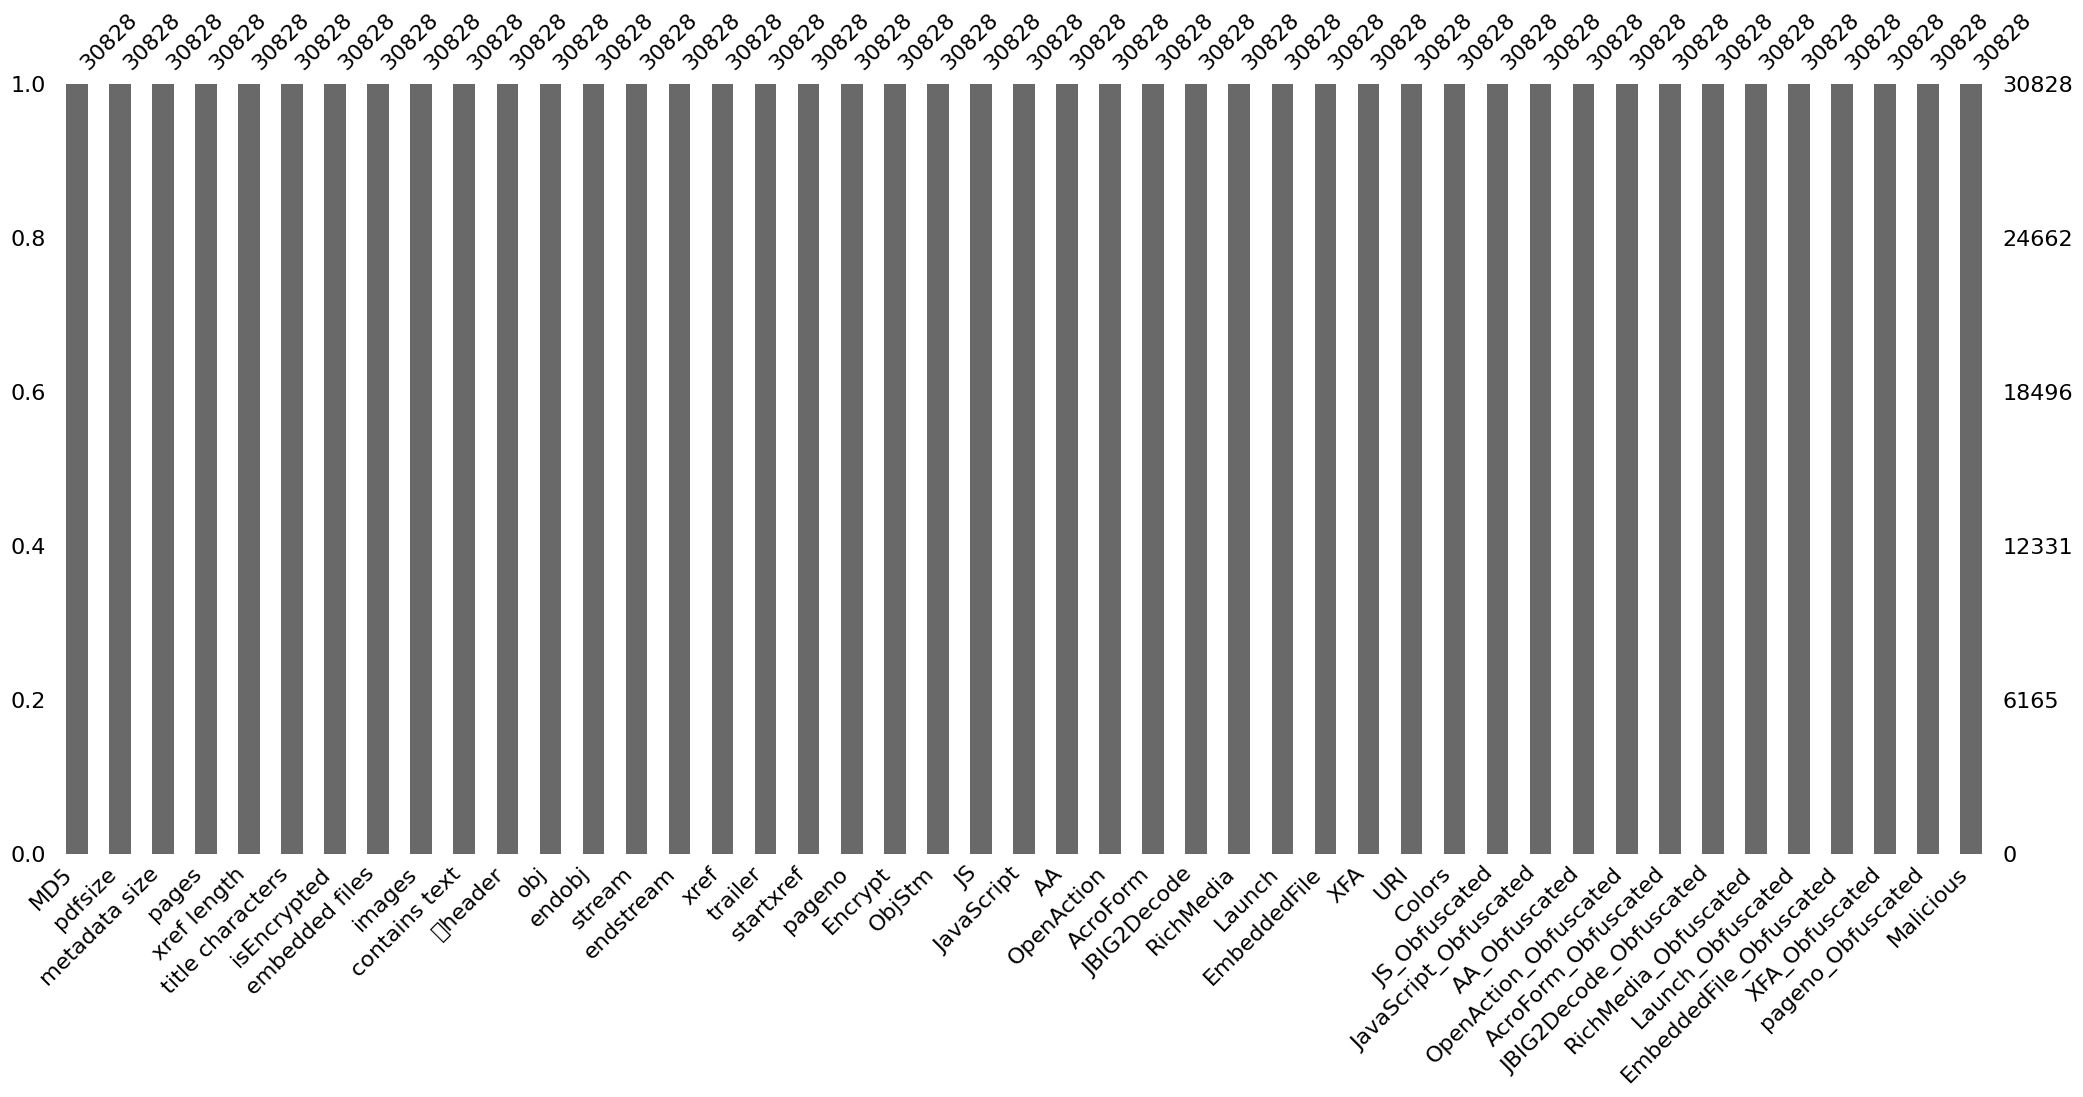

In [17]:

msno.bar(df_pdf);

In [18]:
# store numerical columns to variable
numeric_columns = [x for x in df_pdf.columns if df_pdf[x].dtype != 'object'] # output 12 numerical variables

# identify Imputer
mice_imputer = IterativeImputer()

# Apply imputation
df_pdf[numeric_columns] = mice_imputer.fit_transform(df_pdf[numeric_columns])

In [19]:
# Check missing after applied imputation
df_pdf.isnull().sum()


,0
MD5,0
pdfsize,0
metadata size,0
pages,0
xref length,0
title characters,0
isEncrypted,0
embedded files,0
images,0
contains text,0


In [20]:
sum(df_pdf.isnull().sum())

0

In [21]:
# Drop Fine Name for now..
df_pdf.drop('MD5', axis = 1, inplace= True)

# store categorical columns to independed vaiable
categorical_columns = [x for x in df_pdf.columns if df_pdf[x].dtype == 'object'] # output 20

# Check values of each categorical column that have missing value/s
for i in categorical_columns:
    print('Number of unique values for *{}*'.format(i), df_pdf[i].nunique())

Number of unique values for *contains text* 3
Number of unique values for *	header* 9
Number of unique values for *Malicious* 2


In [22]:
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value
        in column.
        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)
        print(self)
        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

 # Apply miputation Function
df_pdf[categorical_columns] = DataFrameImputer().fit_transform(df_pdf[categorical_columns])

In [23]:
df_pdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30828 entries, 0 to 30827
Data columns (total 44 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   pdfsize                  30828 non-null  float64
 1   metadata size            30828 non-null  float64
 2   pages                    30828 non-null  float64
 3   xref length              30828 non-null  float64
 4   title characters         30828 non-null  float64
 5   isEncrypted              30828 non-null  float64
 6   embedded files           30828 non-null  float64
 7   images                   30828 non-null  float64
 8   contains text            30828 non-null  object 
 9   	header                  30828 non-null  object 
 10  obj                      30828 non-null  float64
 11  endobj                   30828 non-null  float64
 12  stream                   30828 non-null  float64
 13  endstream                30828 non-null  float64
 14  xref                  

In [24]:
# Check duplicate points in our dataset
df_pdf=df_pdf.dropna()
df_pdf.duplicated().sum() # No duplicates

21518

In [25]:
# Check number of samples for each class [Benign, Malicious]
df_pdf.Malicious.value_counts()


,count
Malicious,
Yes,21721
No,9107


In [26]:
data = df_pdf.copy()
data.head()


,pdfsize,metadata size,pages,xref length,title characters,isEncrypted,embedded files,images,contains text,\theader,...,AA_Obfuscated,OpenAction_Obfuscated,AcroForm_Obfuscated,JBIG2Decode_Obfuscated,RichMedia_Obfuscated,Launch_Obfuscated,EmbeddedFile_Obfuscated,XFA_Obfuscated,pageno_Obfuscated,Malicious
0,9.0,180.0,1.0,9.0,0.0,0.0,0.0,0.0,No,\t%PDF-1.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Yes
1,12.0,180.0,1.0,9.0,0.0,0.0,0.0,0.0,No,\tMalformed,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Yes
2,15.0,180.0,1.0,10.0,0.0,0.0,0.0,0.0,No,\t%PDF-1.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Yes
3,16.0,180.0,1.0,10.0,0.0,0.0,0.0,0.0,No,\t%PDF-1.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Yes
4,172.0,271.0,1.0,44.0,0.0,0.0,0.0,0.0,Yes,\t%PDF-1.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,No


## Dropping Obfuscated Columns

In [27]:
data = data.drop(columns=[col for col in data.columns if col.endswith('_Obfuscated')])
data.head()

,pdfsize,metadata size,pages,xref length,title characters,isEncrypted,embedded files,images,contains text,\theader,...,OpenAction,AcroForm,JBIG2Decode,RichMedia,Launch,EmbeddedFile,XFA,URI,Colors,Malicious
0,9.0,180.0,1.0,9.0,0.0,0.0,0.0,0.0,No,\t%PDF-1.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes
1,12.0,180.0,1.0,9.0,0.0,0.0,0.0,0.0,No,\tMalformed,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,Yes
2,15.0,180.0,1.0,10.0,0.0,0.0,0.0,0.0,No,\t%PDF-1.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes
3,16.0,180.0,1.0,10.0,0.0,0.0,0.0,0.0,No,\t%PDF-1.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Yes
4,172.0,271.0,1.0,44.0,0.0,0.0,0.0,0.0,Yes,\t%PDF-1.6,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,No


## Result and text mapping

In [28]:
data["contains text"].unique()

array(['No', 'Yes', 'unclear'], dtype=object)

In [29]:
# Assuming df_pdf is your DataFrame
data.iloc[:, 32] = data.iloc[:, 32].map({'Yes': 1, 'No': 0})
data.iloc[:, 8] = data.iloc[:, 8].map({'Yes': 1, 'No': 0,'unclear':2,"-1":-1,"0":-2})
data.head()

,pdfsize,metadata size,pages,xref length,title characters,isEncrypted,embedded files,images,contains text,\theader,...,OpenAction,AcroForm,JBIG2Decode,RichMedia,Launch,EmbeddedFile,XFA,URI,Colors,Malicious
0,9.0,180.0,1.0,9.0,0.0,0.0,0.0,0.0,0,\t%PDF-1.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,12.0,180.0,1.0,9.0,0.0,0.0,0.0,0.0,0,\tMalformed,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
2,15.0,180.0,1.0,10.0,0.0,0.0,0.0,0.0,0,\t%PDF-1.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,16.0,180.0,1.0,10.0,0.0,0.0,0.0,0.0,0,\t%PDF-1.3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,172.0,271.0,1.0,44.0,0.0,0.0,0.0,0.0,1,\t%PDF-1.6,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


## Converting header values (text to float)

In [30]:
data["\theader"].unique()

array(['\t%PDF-1.3', '\tMalformed', '\t%PDF-1.6', '\t%PDF-1.7',
       '\t%PDF-1.0', '\t%PDF-1.4', '\t%PDF-1.5', '\t%PDF-1.1',
       '\t%PDF-1.2'], dtype=object)

In [31]:
original_values = np.array(['\t%PDF-1.0','\t%PDF-1.1','\t%PDF-1.2','\t%PDF-1.3','\t%PDF-1.4','\t%PDF-1.5','\t%PDF-1.6','\t%PDF-1.7','\tMalformed'])

# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the original values
numeric_values = label_encoder.fit_transform(original_values)

# Create a mapping of original values to numeric values
value_mapping = {original: encoded for original, encoded in zip(original_values, numeric_values)}

# Convert the 10th column using the mapping
data.iloc[:,9] = df_pdf.iloc[:,9].map(value_mapping)

In [32]:
data.head()

,pdfsize,metadata size,pages,xref length,title characters,isEncrypted,embedded files,images,contains text,\theader,...,OpenAction,AcroForm,JBIG2Decode,RichMedia,Launch,EmbeddedFile,XFA,URI,Colors,Malicious
0,9.0,180.0,1.0,9.0,0.0,0.0,0.0,0.0,0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,12.0,180.0,1.0,9.0,0.0,0.0,0.0,0.0,0,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
2,15.0,180.0,1.0,10.0,0.0,0.0,0.0,0.0,0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,16.0,180.0,1.0,10.0,0.0,0.0,0.0,0.0,0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,172.0,271.0,1.0,44.0,0.0,0.0,0.0,0.0,1,6,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


## Converting objects to numeric values

In [33]:

# Assuming 'data' is your DataFrame
data = data.apply(pd.to_numeric, errors='coerce')  # Convert to numeric, setting non-convertible values to NaN
data.fillna(0, inplace=True)  #


data.head() # Ensure data is loaded correctly




,pdfsize,metadata size,pages,xref length,title characters,isEncrypted,embedded files,images,contains text,\theader,...,OpenAction,AcroForm,JBIG2Decode,RichMedia,Launch,EmbeddedFile,XFA,URI,Colors,Malicious
0,9.0,180.0,1.0,9.0,0.0,0.0,0.0,0.0,0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,12.0,180.0,1.0,9.0,0.0,0.0,0.0,0.0,0,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
2,15.0,180.0,1.0,10.0,0.0,0.0,0.0,0.0,0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,16.0,180.0,1.0,10.0,0.0,0.0,0.0,0.0,0,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,172.0,271.0,1.0,44.0,0.0,0.0,0.0,0.0,1,6,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [34]:

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30828 entries, 0 to 30827
Data columns (total 33 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   pdfsize           30828 non-null  float64
 1   metadata size     30828 non-null  float64
 2   pages             30828 non-null  float64
 3   xref length       30828 non-null  float64
 4   title characters  30828 non-null  float64
 5   isEncrypted       30828 non-null  float64
 6   embedded files    30828 non-null  float64
 7   images            30828 non-null  float64
 8   contains text     30828 non-null  int64  
 9   	header           30828 non-null  int64  
 10  obj               30828 non-null  float64
 11  endobj            30828 non-null  float64
 12  stream            30828 non-null  float64
 13  endstream         30828 non-null  float64
 14  xref              30828 non-null  float64
 15  trailer           30828 non-null  float64
 16  startxref         30828 non-null  float6

## Dropping column 1 (index 0), column 5 (index 4), and keeping necessary columns

In [35]:

X = data.drop(columns=[ data.columns[32]])  # Adjusted indices
y = data.iloc[:, 32]
X.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30828 entries, 0 to 30827
Data columns (total 32 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   pdfsize           30828 non-null  float64
 1   metadata size     30828 non-null  float64
 2   pages             30828 non-null  float64
 3   xref length       30828 non-null  float64
 4   title characters  30828 non-null  float64
 5   isEncrypted       30828 non-null  float64
 6   embedded files    30828 non-null  float64
 7   images            30828 non-null  float64
 8   contains text     30828 non-null  int64  
 9   	header           30828 non-null  int64  
 10  obj               30828 non-null  float64
 11  endobj            30828 non-null  float64
 12  stream            30828 non-null  float64
 13  endstream         30828 non-null  float64
 14  xref              30828 non-null  float64
 15  trailer           30828 non-null  float64
 16  startxref         30828 non-null  float6

In [36]:
# Ensure y is aligned with X
y = y.iloc[:X.shape[0]]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# Apply LazyPredict

In [37]:
# from lazypredict.Supervised import LazyClassifier

# # For classification problems
# clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
# models_train, predictions_train = clf.fit(X_train, X_test, y_train, y_test)

# # Display top 3 models
# print("Top 3 models:")
# print(models_train.head(3))

# Random Forest Classifier

In [38]:
# Create and train the model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on test set
y_pred = rf_model.predict(X_test)

# Calculate and print accuracy score
accuracy = rf_model.score(X_test, y_test)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.9971


# Apply Optuna

In [39]:
import optuna
from sklearn.model_selection import cross_val_score

def objective(trial):
    # Define the hyperparameters to optimize
    rf_params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 200),
        'max_depth': trial.suggest_int('max_depth', 2, 32, log=True),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2'])
    }

    # Create and train model
    rf = RandomForestClassifier(**rf_params, random_state=42)

    # Perform cross-validation
    scores = cross_val_score(rf, X, y, cv=5, scoring='accuracy')

    # Return mean accuracy
    return np.mean(scores)

# Create and run study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Get best parameters
best_params = study.best_params
best_score = study.best_value

# Create final model with best parameters
best_rf = RandomForestClassifier(**best_params, random_state=42)


[I 2024-10-25 14:13:27,296] A new study created in memory with name: no-name-abd90806-1df7-4e4e-bd5e-4345022cbc72
[I 2024-10-25 14:13:29,467] Trial 0 finished with value: 0.995588428182806 and parameters: {'n_estimators': 38, 'max_depth': 32, 'min_samples_split': 7, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.995588428182806.
[I 2024-10-25 14:13:34,711] Trial 1 finished with value: 0.9690540675272581 and parameters: {'n_estimators': 182, 'max_depth': 2, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.995588428182806.
[I 2024-10-25 14:13:35,788] Trial 2 finished with value: 0.9951992284823847 and parameters: {'n_estimators': 12, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.995588428182806.
[I 2024-10-25 14:13:40,102] Trial 3 finished with value: 0.968664830997709 and parameters: {'n_estimators': 120, 'max_depth': 2, 'min_sa

In [40]:
print(best_params)
print(best_score)

{'n_estimators': 161, 'max_depth': 30, 'min_samples_split': 6, 'min_samples_leaf': 1, 'max_features': 'log2'}
0.9975671625182599


# Random Forest after Hyperparameter Tuning

In [41]:
best_rf.fit(X_train, y_train)

# Make predictions on test set
y_pred = best_rf.predict(X_test)

# Calculate and print accuracy score
accuracy = best_rf.score(X_test, y_test)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9966


# XGB Classifier

In [42]:
from xgboost import XGBClassifier

# Initialize the model
xgb = XGBClassifier(random_state=42)

# Train the model
xgb.fit(X_train, y_train)

# Make predictions on test set
y_pred = xgb.predict(X_test)

# Get accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9969


# Apply Optuna

In [43]:
import optuna
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

def objective(trial):
    # Define the hyperparameters to optimize
    params = {
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
    }

    # Create and train model
    model = XGBClassifier(**params)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

# Create and run study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Get best parameters and score
print('Best trial:')
print('  Value: ', study.best_trial.value)
print('  Params: ')
for key, value in study.best_trial.params.items():
    print(f'    {key}: {value}')

# Train final model with best parameters
best_xgb = XGBClassifier(**study.best_trial.params)
best_xgb.fit(X_train, y_train)

[I 2024-10-25 14:30:14,885] A new study created in memory with name: no-name-4167dd99-3195-47eb-9f17-cc8945328dbc
[I 2024-10-25 14:30:15,457] Trial 0 finished with value: 0.9967564060979566 and parameters: {'max_depth': 8, 'learning_rate': 0.26615282625436987, 'n_estimators': 163, 'min_child_weight': 1, 'subsample': 0.6410583681779706, 'colsample_bytree': 0.9857492843271034}. Best is trial 0 with value: 0.9967564060979566.
[I 2024-10-25 14:30:15,860] Trial 1 finished with value: 0.9967564060979566 and parameters: {'max_depth': 7, 'learning_rate': 0.07743484997311403, 'n_estimators': 114, 'min_child_weight': 4, 'subsample': 0.8983653119926064, 'colsample_bytree': 0.8078279140786235}. Best is trial 0 with value: 0.9967564060979566.
[I 2024-10-25 14:30:16,271] Trial 2 finished with value: 0.9936749918910153 and parameters: {'max_depth': 2, 'learning_rate': 0.09310333891601952, 'n_estimators': 169, 'min_child_weight': 4, 'subsample': 0.7833979167422906, 'colsample_bytree': 0.95792729022937

Best trial:
  Value:  0.9977294842685696
  Params: 
    max_depth: 3
    learning_rate: 0.27036313501766424
    n_estimators: 210
    min_child_weight: 1
    subsample: 0.8794485941314489
    colsample_bytree: 0.9761111407902864


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9761111407902864, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.27036313501766424,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=210, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

# XGB after Hyperparameter Tuning

In [44]:
# Train the model
best_xgb.fit(X_train, y_train)

# Make predictions on test set
y_pred = best_xgb.predict(X_test)

# Get accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9977


# Extra Trees Classifier

In [45]:
from sklearn.ensemble import ExtraTreesClassifier

# Initialize the model
etc = ExtraTreesClassifier(random_state=42)

# Train the model
etc.fit(X_train, y_train)

# Make predictions
y_pred = etc.predict(X_test)

# Calculate accuracy
accuracy = etc.score(X_test, y_test)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9971


# Apply Optuna

In [46]:
import optuna
from sklearn.metrics import accuracy_score

def objective(trial):
    # Define hyperparameters to optimize
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 200),
        'max_depth': trial.suggest_int('max_depth', 2, 32, log=True),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
    }

    # Create and train model
    model = ExtraTreesClassifier(**params, random_state=42)
    model.fit(X_train, y_train)

    # Make predictions and evaluate
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)

    return accuracy

# Create and run study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Get best parameters and score
print('Best parameters:', study.best_params)
print('Best accuracy:', study.best_value)

# Train final model with best parameters
best_model = ExtraTreesClassifier(**study.best_params, random_state=42)
best_model.fit(X_train, y_train)

[I 2024-10-25 14:32:12,862] A new study created in memory with name: no-name-711cc978-ed0c-4fde-a04e-3675c3a4add3
[I 2024-10-25 14:32:13,066] Trial 0 finished with value: 0.8301978592280247 and parameters: {'n_estimators': 47, 'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8301978592280247.
[I 2024-10-25 14:32:14,241] Trial 1 finished with value: 0.9870256243918262 and parameters: {'n_estimators': 153, 'max_depth': 23, 'min_samples_split': 2, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.9870256243918262.
[I 2024-10-25 14:32:14,417] Trial 2 finished with value: 0.9946480700616283 and parameters: {'n_estimators': 16, 'max_depth': 27, 'min_samples_split': 13, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.9946480700616283.
[I 2024-10-25 14:32:14,618] Trial 3 finished with value: 0.9557249432371067 and parameters: {'n_estimators': 26, 'max_depth': 11, 'min_samples_split': 18, 'min_samples_leaf': 7}. Best is trial 2 with value:

Best parameters: {'n_estimators': 28, 'max_depth': 32, 'min_samples_split': 12, 'min_samples_leaf': 1}
Best accuracy: 0.9970807654881609


ExtraTreesClassifier(max_depth=32, min_samples_split=12, n_estimators=28,
                     random_state=42)

# Extra Trees Classifier after Hyperparameter Tuning

In [47]:
# Train the model
best_model.fit(X_train, y_train)

# Make predictions
y_pred = best_model.predict(X_test)

# Calculate accuracy
accuracy = best_model.score(X_test, y_test)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.9971


# RF, ETC and XGB as Base Learners

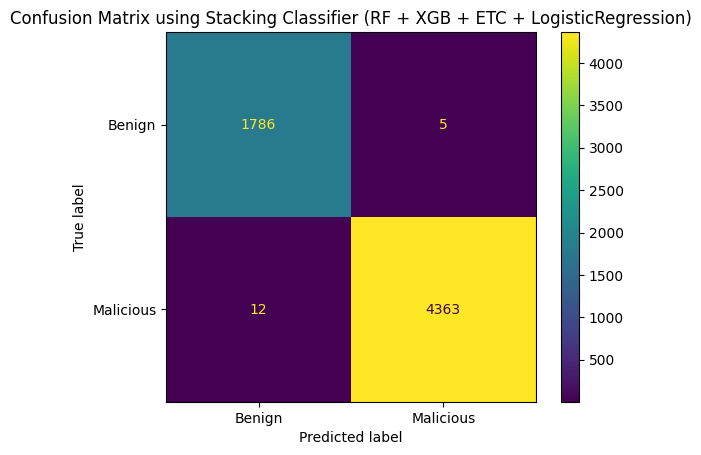

False Positive Rate: 0.0027917364600781687
True Positive Rate: 0.9972571428571428
Accuracy Score: 0.9972429451832631


In [48]:
logistic_meta = LogisticRegression(random_state=42)

stacking_model = StackingClassifier(
    estimators=[
        ('rf', best_rf),  # Random Forest base model
        ('xgb', best_xgb),  # XGB base model
        ('etc', best_model)  # ETC base model
    ],
    final_estimator=logistic_meta,  # Meta learner (LogisticRegression)
    cv=5  # Cross-validation for robustness
)

# Train the stacking model
stacking_model.fit(X_train, y_train)

# Make predictions using the stacking model
y_pred_stacking = stacking_model.predict(X_test)

# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stacking).ravel()
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_stacking), display_labels=['Benign', 'Malicious']).plot()
plt.title('Confusion Matrix using Stacking Classifier (RF + XGB + ETC + LogisticRegression)')
plt.show()

# Print Performance Metrics
print(f'False Positive Rate: {fp / (fp + tn)}')
print(f'True Positive Rate: {tp / (tp + fn)}')
print(f'Accuracy Score: {accuracy_score(y_test, y_pred_stacking)}')


RF, XGB, ETC, ADABoost and MLP

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

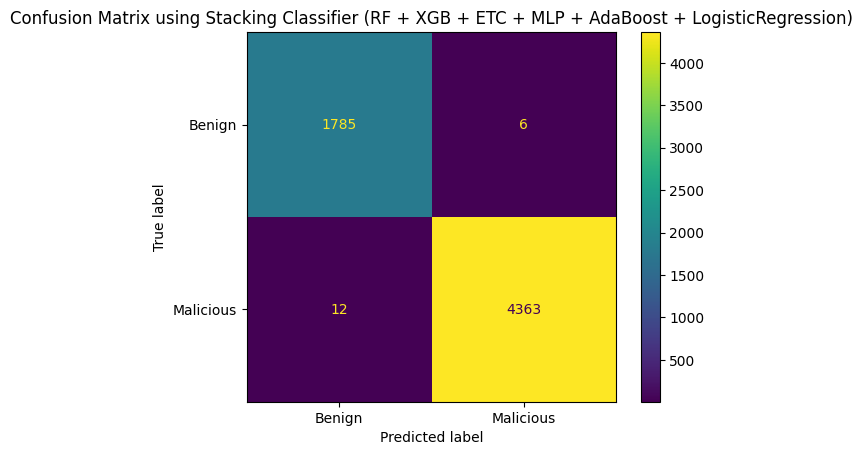

False Positive Rate: 0.0033500837520938024
True Positive Rate: 0.9972571428571428
Accuracy Score: 0.9970807654881609


In [49]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

# Assuming X_train, X_test, y_train, y_test, and best models (best_rf, best_xgb, best_model) are already defined

# Meta Learner: Logistic Regression
logistic_meta = LogisticRegression(random_state=42)

# Define the Stacking Classifier with additional base models (MLP and AdaBoost)
stacking_model = StackingClassifier(
    estimators=[
        ('rf', best_rf),       # Random Forest base model
        ('xgb', best_xgb),     # XGB base model
        ('etc', best_model),   # Extra Trees base model
        ('mlp', MLPClassifier(hidden_layer_sizes=(100,), max_iter=200, random_state=42)),  # MLP base model
        ('ada', AdaBoostClassifier(n_estimators=50, random_state=42))  # AdaBoost base model
    ],
    final_estimator=logistic_meta,  # Meta learner (LogisticRegression)
    cv=5  # Cross-validation for robustness
)

# Train the stacking model
stacking_model.fit(X_train, y_train)

# Make predictions using the stacking model
y_pred_stacking = stacking_model.predict(X_test)

# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stacking).ravel()
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_stacking), display_labels=['Benign', 'Malicious']).plot()
plt.title('Confusion Matrix using Stacking Classifier (RF + XGB + ETC + MLP + AdaBoost + LogisticRegression)')
plt.show()

# Print Performance Metrics
print(f'False Positive Rate: {fp / (fp + tn)}')
print(f'True Positive Rate: {tp / (tp + fn)}')
print(f'Accuracy Score: {accuracy_score(y_test, y_pred_stacking)}')


RF, ETC, XGB, MLP

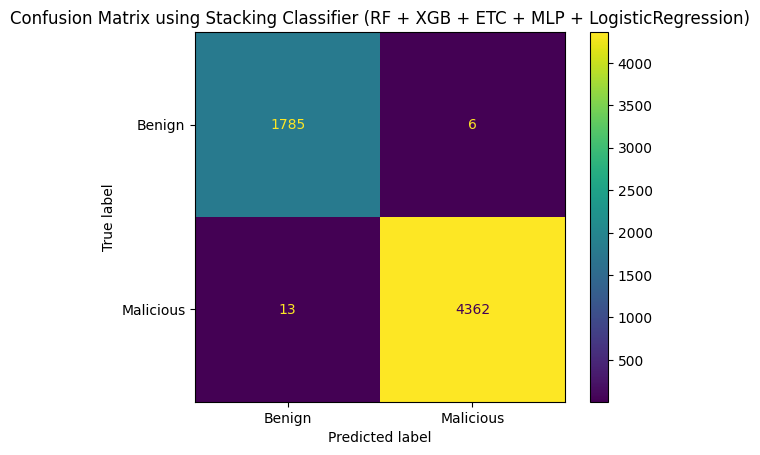

False Positive Rate: 0.0033500837520938024
True Positive Rate: 0.9970285714285714
Accuracy Score: 0.9969185857930587


In [50]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

# Assuming X_train, X_test, y_train, y_test, and best models (best_rf, best_xgb, best_model) are already defined

# Meta Learner: Logistic Regression
logistic_meta = LogisticRegression(random_state=42)

# Define the Stacking Classifier with XGBoost, RF, ETC, and MLP as base models
stacking_model = StackingClassifier(
    estimators=[
        ('rf', best_rf),       # Random Forest base model
        ('xgb', best_xgb),     # XGB base model
        ('etc', best_model),   # Extra Trees base model
        ('mlp', MLPClassifier(hidden_layer_sizes=(100,), max_iter=200, random_state=42))  # MLP base model
    ],
    final_estimator=logistic_meta,  # Meta learner (LogisticRegression)
    cv=5  # Cross-validation for robustness
)

# Train the stacking model
stacking_model.fit(X_train, y_train)

# Make predictions using the stacking model
y_pred_stacking = stacking_model.predict(X_test)

# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stacking).ravel()
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_stacking), display_labels=['Benign', 'Malicious']).plot()
plt.title('Confusion Matrix using Stacking Classifier (RF + XGB + ETC + MLP + LogisticRegression)')
plt.show()

# Print Performance Metrics
print(f'False Positive Rate: {fp / (fp + tn)}')
print(f'True Positive Rate: {tp / (tp + fn)}')
print(f'Accuracy Score: {accuracy_score(y_test, y_pred_stacking)}')


XGB, ETC, RF and ADABoost

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

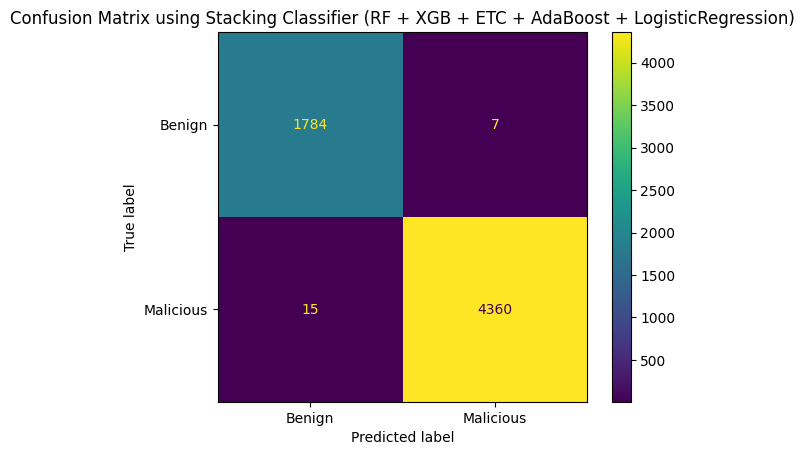

False Positive Rate: 0.003908431044109436
True Positive Rate: 0.9965714285714286
Accuracy Score: 0.9964320467077522


In [53]:
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

# Assuming X_train, X_test, y_train, y_test, and best models (best_rf, best_xgb, best_model) are already defined

# Meta Learner: Logistic Regression
logistic_meta = LogisticRegression(random_state=42)

# Define the Stacking Classifier with RF, XGB, ETC, and AdaBoost as base models
stacking_model = StackingClassifier(
    estimators=[
        ('rf', best_rf),       # Random Forest base model
        ('xgb', best_xgb),     # XGBoost base model
        ('etc', best_model),   # Extra Trees base model
        ('ada', AdaBoostClassifier(n_estimators=50, random_state=42))  # AdaBoost base model
    ],
    final_estimator=logistic_meta,  # Meta learner (LogisticRegression)
    cv=5  # Cross-validation for robustness
)

# Train the stacking model
stacking_model.fit(X_train, y_train)

# Make predictions using the stacking model
y_pred_stacking = stacking_model.predict(X_test)

# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stacking).ravel()
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_stacking), display_labels=['Benign', 'Malicious']).plot()
plt.title('Confusion Matrix using Stacking Classifier (RF + XGB + ETC + AdaBoost + LogisticRegression)')
plt.show()

# Print Performance Metrics
print(f'False Positive Rate: {fp / (fp + tn)}')
print(f'True Positive Rate: {tp / (tp + fn)}')
print(f'Accuracy Score: {accuracy_score(y_test, y_pred_stacking)}')


RF, XGB, ETC, ADABoost as Base and XGB as Meta

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

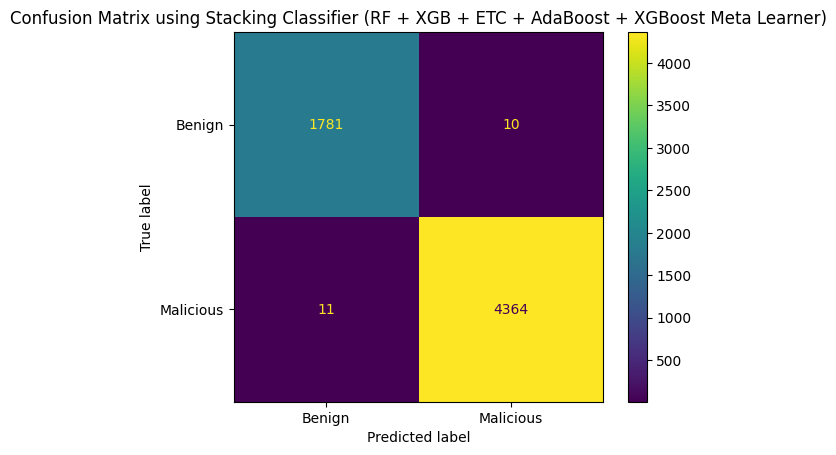

False Positive Rate: 0.005583472920156337
True Positive Rate: 0.9974857142857143
Accuracy Score: 0.9965942264028543


In [54]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

# Assuming X_train, X_test, y_train, y_test are already defined and preprocessed

# Define optimized base learners
rf_base = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
xgb_base = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
etc_base = ExtraTreesClassifier(n_estimators=100, max_depth=10, random_state=42)
ada_base = AdaBoostClassifier(n_estimators=100, random_state=42)

# Define the meta learner as XGBoost for its strength in ensemble learning
meta_learner = XGBClassifier(n_estimators=50, max_depth=3, learning_rate=0.1, random_state=42)

# Set up the stacking model
stacking_model = StackingClassifier(
    estimators=[
        ('rf', rf_base),       # Random Forest base model
        ('xgb', xgb_base),     # XGBoost base model
        ('etc', etc_base),     # Extra Trees base model
        ('ada', ada_base)      # AdaBoost base model
    ],
    final_estimator=meta_learner,  # Meta learner (XGBoost)
    cv=5  # Cross-validation for robustness
)

# Train the stacking model
stacking_model.fit(X_train, y_train)

# Make predictions
y_pred_stacking = stacking_model.predict(X_test)

# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stacking).ravel()
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_stacking), display_labels=['Benign', 'Malicious']).plot()
plt.title('Confusion Matrix using Stacking Classifier (RF + XGB + ETC + AdaBoost + XGBoost Meta Learner)')
plt.show()

# Print Performance Metrics
print(f'False Positive Rate: {fp / (fp + tn)}')
print(f'True Positive Rate: {tp / (tp + fn)}')
print(f'Accuracy Score: {accuracy_score(y_test, y_pred_stacking)}')


Updated Code with More Complexity and LightGBM as Meta Learner

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 17346, number of negative: 7316
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1012
[LightGBM] [Info] Number of data points in the train set: 24662, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.703349 -> initscore=0.863298
[LightGBM] [Info] Start training from score 0.863298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

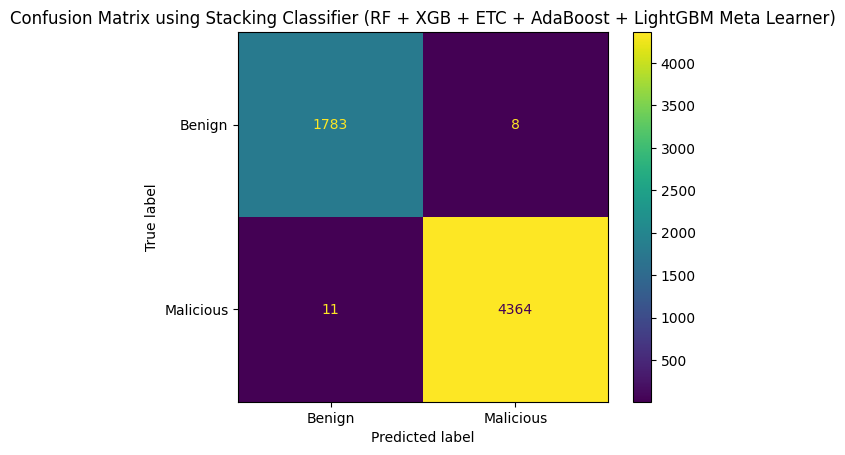

False Positive Rate: 0.00446677833612507
True Positive Rate: 0.9974857142857143
Accuracy Score: 0.9969185857930587


In [57]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

# Assuming X_train, X_test, y_train, y_test are already defined and preprocessed

# Define optimized base learners
rf_base = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42)
xgb_base = XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.05, random_state=42)
etc_base = ExtraTreesClassifier(n_estimators=200, max_depth=15, random_state=42)
ada_base = AdaBoostClassifier(n_estimators=200, random_state=42)

# Use LightGBM as the meta learner for a boost in performance
meta_learner = LGBMClassifier(n_estimators=100, max_depth=5, learning_rate=0.05, random_state=42)

# Set up the stacking model with complex base learners
stacking_model = StackingClassifier(
    estimators=[
        ('rf', rf_base),       # Random Forest base model
        ('xgb', xgb_base),     # XGBoost base model
        ('etc', etc_base),     # Extra Trees base model
        ('ada', ada_base)      # AdaBoost base model
    ],
    final_estimator=meta_learner,  # Meta learner (LightGBM)
    cv=10  # Cross-validation for robustness
)

# Train the stacking model
stacking_model.fit(X_train, y_train)

# Make predictions using the stacking model
y_pred_stacking = stacking_model.predict(X_test)

# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stacking).ravel()
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_stacking), display_labels=['Benign', 'Malicious']).plot()
plt.title('Confusion Matrix using Stacking Classifier (RF + XGB + ETC + AdaBoost + LightGBM Meta Learner)')
plt.show()

# Print Performance Metrics
print(f'False Positive Rate: {fp / (fp + tn)}')
print(f'True Positive Rate: {tp / (tp + fn)}')
print(f'Accuracy Score: {accuracy_score(y_test, y_pred_stacking)}')


In [56]:
!pip install dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.6/242.6 kB 4.5 MB/s eta 0:00:00


Two layer stacking model

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 17346, number of negative: 7316
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1011
[LightGBM] [Info] Number of data points in the train set: 24662, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.703349 -> initscore=0.863298
[LightGBM] [Info] Start training from score 0.863298
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 13877, number of negative: 5852
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1008
[LightGBM] [Info] Number of data points in the train set: 19729, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.703381 -> initscore=0.863449
[LightGBM] [Info] Start training from score 0.863449
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 13876, number of negative: 5853
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1017
[LightGBM] [Info] Number of data points in the train set: 19729, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.703330 -> initscore=0.863206
[LightGBM] [Info] Start training from score 0.863206
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 13877, number of negative: 5853
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1007
[LightGBM] [Info] Number of data points in the train set: 19730, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.703345 -> initscore=0.863278
[LightGBM] [Info] Start training from score 0.863278
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 13877, number of negative: 5853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1010
[LightGBM] [Info] Number of data points in the train set: 19730, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.703345 -> initscore=0.863278
[LightGBM] [Info] Start training from score 0.863278
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

[LightGBM] [Info] Number of positive: 13877, number of negative: 5853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000347 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1014
[LightGBM] [Info] Number of data points in the train set: 19730, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.703345 -> initscore=0.863278
[LightGBM] [Info] Start training from score 0.863278
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

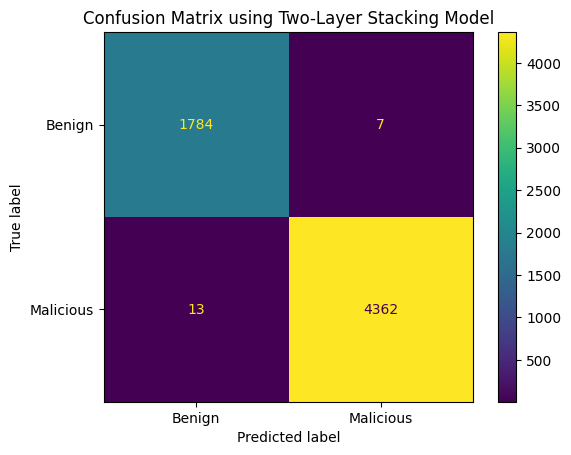

False Positive Rate: 0.003908431044109436
True Positive Rate: 0.9970285714285714
Accuracy Score: 0.9967564060979566


In [58]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, StackingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Assuming X_train, X_test, y_train, y_test are already defined

# Define individual base learners
rf_base = RandomForestClassifier(n_estimators=150, max_depth=12, random_state=42)
xgb_base = XGBClassifier(n_estimators=150, max_depth=4, learning_rate=0.05, random_state=42)
etc_base = ExtraTreesClassifier(n_estimators=150, max_depth=12, random_state=42)
ada_base = AdaBoostClassifier(n_estimators=150, random_state=42)

# First Stacking Layer: Multiple stacking models with different meta learners
stacking_model_1 = StackingClassifier(
    estimators=[
        ('rf', rf_base),
        ('xgb', xgb_base),
        ('etc', etc_base),
        ('ada', ada_base)
    ],
    final_estimator=LogisticRegression(),  # Meta learner for first stacking model
    cv=5
)

stacking_model_2 = StackingClassifier(
    estimators=[
        ('rf', rf_base),
        ('xgb', xgb_base),
        ('etc', etc_base),
        ('ada', ada_base)
    ],
    final_estimator=LGBMClassifier(n_estimators=50, max_depth=3, learning_rate=0.05, random_state=42),  # Meta learner for second stacking model
    cv=5
)

# Second Stacking Layer: Combine outputs of the first-layer stacking models
final_meta_learner = XGBClassifier(n_estimators=50, max_depth=3, learning_rate=0.1, random_state=42)
layered_stacking_model = StackingClassifier(
    estimators=[
        ('stack_1', stacking_model_1),
        ('stack_2', stacking_model_2)
    ],
    final_estimator=final_meta_learner,
    cv=5
)

# Train the layered stacking model
layered_stacking_model.fit(X_train, y_train)

# Make predictions using the layered stacking model
y_pred_stacking = layered_stacking_model.predict(X_test)

# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_stacking).ravel()
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_stacking), display_labels=['Benign', 'Malicious']).plot()
plt.title('Confusion Matrix using Two-Layer Stacking Model')
plt.show()

# Print Performance Metrics
print(f'False Positive Rate: {fp / (fp + tn)}')
print(f'True Positive Rate: {tp / (tp + fn)}')
print(f'Accuracy Score: {accuracy_score(y_test, y_pred_stacking)}')


Implementation: Weighted Averaging of Predictions (Blending)
Here's a possible implementation where we train the two-layer stacking model, but instead of a final meta-learner, we use a custom-weighted average of predictions. This approach might allow for more fine-grained control over the final prediction.

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.1

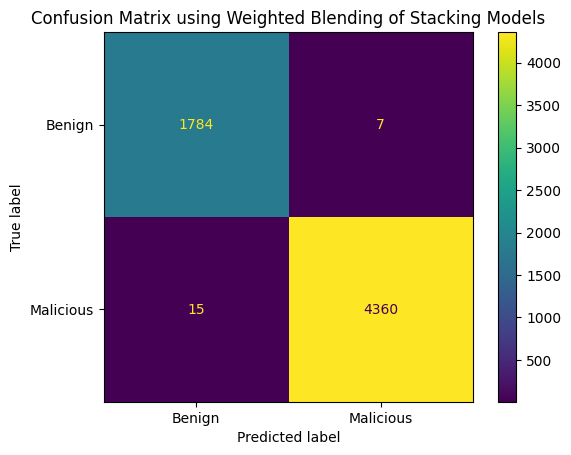

False Positive Rate: 0.003908431044109436
True Positive Rate: 0.9965714285714286
Accuracy Score: 0.9964320467077522


In [51]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

# Assuming X_train, X_test, y_train, y_test are already defined

# Define individual base learners
rf_base = RandomForestClassifier(n_estimators=150, max_depth=12, random_state=42)
xgb_base = XGBClassifier(n_estimators=150, max_depth=4, learning_rate=0.05, random_state=42)
etc_base = ExtraTreesClassifier(n_estimators=150, max_depth=12, random_state=42)
ada_base = AdaBoostClassifier(n_estimators=150, random_state=42)

# First Stacking Layer: Multiple stacking models with different meta learners
stacking_model_1 = StackingClassifier(
    estimators=[
        ('rf', rf_base),
        ('xgb', xgb_base),
        ('etc', etc_base),
        ('ada', ada_base)
    ],
    final_estimator=LogisticRegression(),  # Meta learner for first stacking model
    cv=5
)

stacking_model_2 = StackingClassifier(
    estimators=[
        ('rf', rf_base),
        ('xgb', xgb_base),
        ('etc', etc_base),
        ('ada', ada_base)
    ],
    final_estimator=XGBClassifier(n_estimators=50, max_depth=3, learning_rate=0.1, random_state=42),  # Meta learner
    cv=5
)

# Train both stacking models
stacking_model_1.fit(X_train, y_train)
stacking_model_2.fit(X_train, y_train)

# Predict probabilities from each stacking model
y_pred_prob_stack1 = stacking_model_1.predict_proba(X_test)
y_pred_prob_stack2 = stacking_model_2.predict_proba(X_test)

# Custom Weighted Blending of Predictions
# Adjust weights based on each model's performance
weight_stack1 = 0.6
weight_stack2 = 0.4

y_pred_blended = np.argmax(weight_stack1 * y_pred_prob_stack1 + weight_stack2 * y_pred_prob_stack2, axis=1)

# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_blended).ravel()
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_blended), display_labels=['Benign', 'Malicious']).plot()
plt.title('Confusion Matrix using Weighted Blending of Stacking Models')
plt.show()

# Print Performance Metrics
print(f'False Positive Rate: {fp / (fp + tn)}')
print(f'True Positive Rate: {tp / (tp + fn)}')
print(f'Accuracy Score: {accuracy_score(y_test, y_pred_blended)}')


Blending with Weighted Voting Based on Accuracy

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


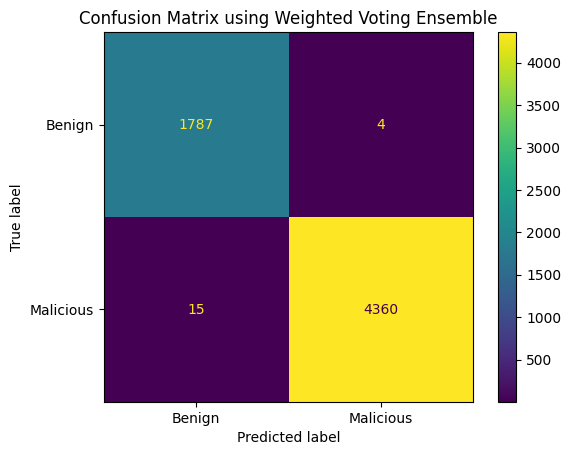

False Positive Rate: 0.002233389168062535
True Positive Rate: 0.9965714285714286
Accuracy Score: 0.9969185857930587


In [52]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Assuming X_train, X_test, y_train, y_test are already defined

# Define individual models with tuned hyperparameters
rf_base = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42)
xgb_base = XGBClassifier(n_estimators=200, max_depth=5, learning_rate=0.05, random_state=42)
etc_base = ExtraTreesClassifier(n_estimators=200, max_depth=15, random_state=42)
ada_base = AdaBoostClassifier(n_estimators=200, random_state=42)

# Train each model and get individual accuracy on the validation set
models = [('rf', rf_base), ('xgb', xgb_base), ('etc', etc_base), ('ada', ada_base)]

# Initialize VotingClassifier with soft voting and custom weights
voting_ensemble = VotingClassifier(
    estimators=models,
    voting='soft',
    weights=[0.35, 0.3, 0.2, 0.15]  # Adjust these weights based on model performance on validation set
)

# Train the weighted voting ensemble model
voting_ensemble.fit(X_train, y_train)

# Make predictions using the voting ensemble
y_pred_voting = voting_ensemble.predict(X_test)

# Confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_voting).ravel()
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred_voting), display_labels=['Benign', 'Malicious']).plot()
plt.title('Confusion Matrix using Weighted Voting Ensemble')
plt.show()

# Print Performance Metrics
print(f'False Positive Rate: {fp / (fp + tn)}')
print(f'True Positive Rate: {tp / (tp + fn)}')
print(f'Accuracy Score: {accuracy_score(y_test, y_pred_voting)}')
